# Proyecto 02: Modelos avanzados para el análisis del mercado inmobiliario

## Parte A: Transformación de datos

### 1. Preliminares

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

In [3]:
# Cargamos el dataset
dataProperati = pd.read_csv('DS_Proyecto_01_Datos_Properati.csv', encoding='utf-8')
dataProperati.shape

(146660, 19)

Antes que todo, haremos una limpieza del dataset original para eliminar aquellas instancias duplicadas en todas sus columnas excepto en el precio, pues esto probablemente significa que bajaron el precio del inmueble y este precio sería el pertinente para hacer el análisis. Observando el dataset nos damos cuenta que está organizado de manera descendente según la fecha de publicación, por lo que el valor a dejar al hacer la limpieza de duplicados, será el primero que encuentre.

In [4]:
# Elimino los duplicados en todas sus columnas excepto en "start_date", "end_date", "created_on" y "price"
dataProperati = dataProperati.drop_duplicates(subset=dataProperati.columns.difference(['start_date','end_date','created_on','price']), keep='first')
dataProperati.shape

(112594, 19)

Volvemos al dataset filtrado del Proyecto 01, dónde unicamente están las propiedades ubicadas en la `Capital Federal` que son de tipo `Departamento`, `Casa` y `PH`. 

In [5]:
dataP2 = dataProperati[(dataProperati['l2'] == 'Capital Federal') & 
                       ((dataProperati['property_type'].isin(['Departamento', 'PH', 'Casa'])))].copy()

# Eliminamos columnas que no utilizaremos en el análisis
dataP2= dataP2.drop(columns=['start_date', 'end_date', 'created_on', 'description', 
                                   'operation_type','currency','title'])

dataP2.shape

(63161, 12)

### 2 Imputación

Acá realizamos un poco de análisis de datos faltantes, porque si se hace la eliminación de outliers antes, eliminaría todas estas instancias sin haberlas analizado primero.

In [6]:
dataP2[dataP2.isna().any(axis=1)]

,lat,lon,l1,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type
35,NaN,NaN,Argentina,Capital Federal,Palermo,2.0,1.0,2.0,81.0,76.0,410000.0,Departamento
36,NaN,NaN,Argentina,Capital Federal,Palermo,2.0,1.0,1.0,42.0,38.0,169000.0,Departamento
46,NaN,NaN,Argentina,Capital Federal,Palermo,2.0,1.0,1.0,52.0,46.0,159500.0,Departamento
86,NaN,NaN,Argentina,Capital Federal,Balvanera,2.0,1.0,1.0,43.0,40.0,109000.0,Departamento
103,NaN,NaN,Argentina,Capital Federal,Barrio Norte,2.0,1.0,2.0,95.0,65.0,360000.0,Departamento
...,...,...,...,...,...,...,...,...,...,...,...,...
146520,NaN,NaN,Argentina,Capital Federal,Palermo,3.0,2.0,2.0,73.0,66.0,330000.0,Departamento
146521,NaN,NaN,Argentina,Capital Federal,Palermo,1.0,1.0,1.0,73.0,66.0,150000.0,Departamento
146525,NaN,NaN,Argentina,Capital Federal,Palermo,2.0,1.0,2.0,67.0,67.0,230000.0,Departamento
146547,NaN,NaN,Argentina,Capital Federal,Palermo,3.0,2.0,2.0,82.0,82.0,585000.0,Departamento


In [7]:
from prettytable import PrettyTable

colData = dataP2.columns

valNan = PrettyTable()

valNan.field_names = ['Columna','# Valores faltantes']

for a in range(len(colData)):
    valNan1 = dataP2[colData[a]].isna().sum()
    valNan.add_row([colData[a],valNan1])

print(valNan)

+-----------------+---------------------+
|     Columna     | # Valores faltantes |
+-----------------+---------------------+
|       lat       |         2886        |
|       lon       |         2900        |
|        l1       |          0          |
|        l2       |          0          |
|        l3       |          0          |
|      rooms      |          0          |
|     bedrooms    |          0          |
|    bathrooms    |         2029        |
|  surface_total  |         8472        |
| surface_covered |         8741        |
|      price      |          0          |
|  property_type  |          0          |
+-----------------+---------------------+


Vamos a borrar todas las instancias faltantes de la columna de baños, latitud y longitud debido a que consideramos que es sobre la que más sesgo puede generarse al hacer una imputación, pues tiene un rango de valores muy reducido.

Para el caso de los valores faltantes en surface, lo que haremos es que, si solo tiene un valor, ya sea en `surface_covered` o `surface_total`, se le imputará al valor faltante el que ya existe. El resto de datos se eliminarán para no generar sesgo.

In [8]:
# Borramos las filas con valores faltantes en "bathrooms"
dataP2 = dataP2.dropna(subset=['bathrooms','lat','lon'])
print(dataP2.shape)

# Borramos las filas con valores faltantes tanto en "surface_total" como "surface_covered"
dataP2 = dataP2.dropna(subset=['surface_total', 'surface_covered'], how='all')

# Llenamos los valores faltantes en "surface_total" con los valores de "surface_covered"
dataP2['surface_total'].fillna(dataP2['surface_covered'], inplace=True)

# Llenamos los valores faltantes en "surface_covered" con los valores de "surface_total"
dataP2['surface_covered'].fillna(dataP2['surface_total'], inplace=True)
print(dataP2.shape)

# Borramos las filas con valores faltantes tanto en "surface_total" como "surface_covered"
dataP2 = dataP2.dropna(subset=['surface_total', 'surface_covered'], how='all')


dataP2.shape
dataP2.isna().sum()

(58286, 12)
(51432, 12)


lat                0
lon                0
l1                 0
l2                 0
l3                 0
rooms              0
bedrooms           0
bathrooms          0
surface_total      0
surface_covered    0
price              0
property_type      0
dtype: int64

### 3. Detección y eliminación de outliers

Para iniciar, graficaremos la distribución de cada una de las variables involucradas en el problema y su diagrama de cajas

C:\Users\Administrador\.conda\envs\databien\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Administrador\.conda\envs\databien\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Administrador\.conda\envs\databien\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level func

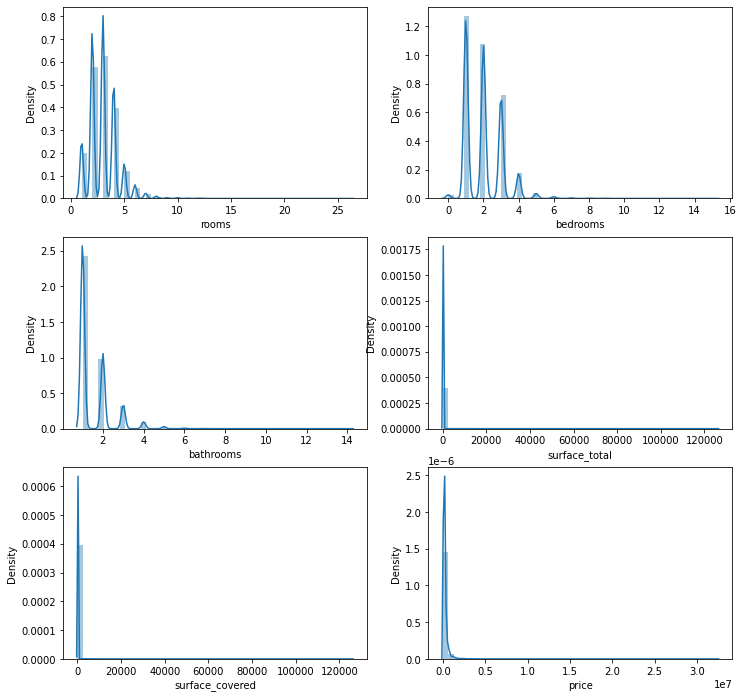

In [9]:
# Definimos la figura y la malla para la impresión
fig, axes = plt.subplots(3, 2, sharex=False, sharey=False, figsize=(12,12))
var_dist = ['rooms','bedrooms','bathrooms','surface_total','surface_covered','price']

# Definimos el ciclo para que imprima cada una de las distribuciones
for i, ax in enumerate(axes.flat):
#     if i == 0:
#         ax.set_ylim(0,50)
    sns.distplot(dataP2[var_dist[i]], ax=ax)

# # Quitar warnings
# import warnings
# warnings.filterwarnings("ignore")
# warnings.simplefilter('always', category=UserWarning)

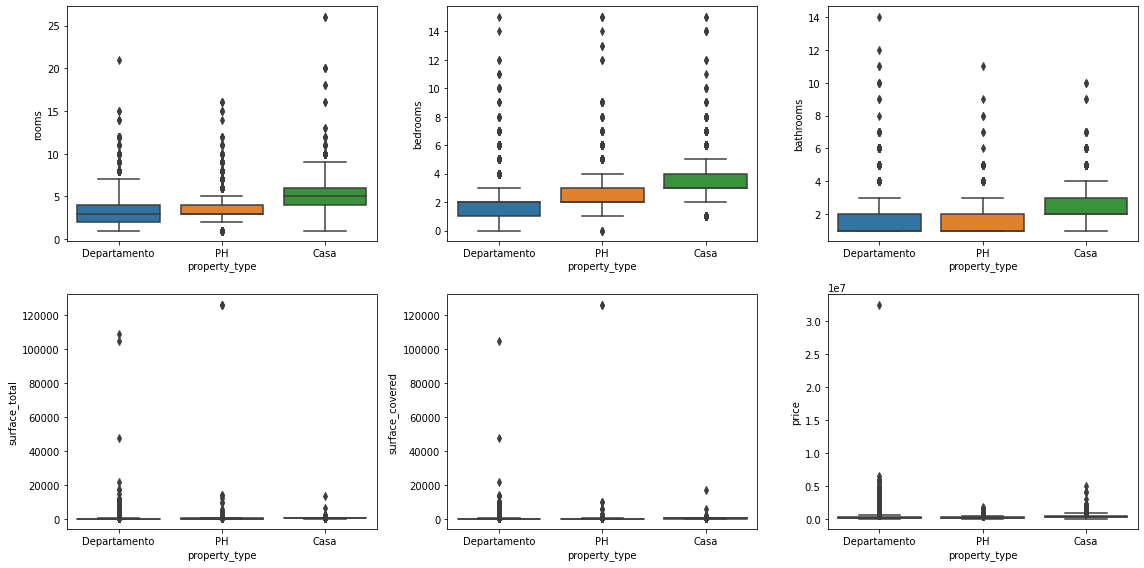

In [10]:
# Imprimimos diagramas de cajas para cada una de las 

fig, axes = plt.subplots(2, 3, figsize=(16,8))

sns.boxplot(ax=axes[0,0], data=dataP2, x='property_type', y='rooms')

sns.boxplot(ax=axes[0,1], data=dataP2, x='property_type', y='bedrooms')

sns.boxplot(ax=axes[0,2], data=dataP2, x='property_type', y='bathrooms')

#axes[1,0].set_ylim([0,800])
sns.boxplot(ax=axes[1,0], data=dataP2, x='property_type', y='surface_total')

#axes[1,1].set_ylim([0,1000])
sns.boxplot(ax=axes[1,1], data=dataP2, x='property_type', y='surface_covered')

#axes[1,2].set_ylim([0,2000000])
sns.boxplot(ax=axes[1,2], data=dataP2, x='property_type', y='price')

plt.tight_layout()

Podemos notar que los outliers se concentran en la cola derecha de las distribuciones, es decir, en los valores más grandes, por lo cual aplicaremos el rango intercuartil pero no con un valor de <b>1.5</b> si no de <b>3</b> para el lado derecho de la distribución

In [11]:
# Definimos las columnas sobre las cuales haremos la limpieza
cols_data = ['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered', 'price']

for a in range(len(cols_data)):
    # Determinamos el cuartil 25
    Q1 = dataP2[cols_data[a]].quantile(0.25)
    # Determinamos el cuartil 75
    Q3 = dataP2[cols_data[a]].quantile(0.75)
    # Determinamos el rango intercuartil
    IQR = Q3 - Q1
    # Filtramos los valores
    filter = (dataP2[cols_data[a]] >= Q1 - 1.5 * IQR) & (dataP2[cols_data[a]] <= Q3 + 3 * IQR)
    dataP2 = dataP2.loc[filter]

# Muestra las dimensiones del nuevo dataset
print(dataP2.shape)

(47573, 12)


C:\Users\Administrador\.conda\envs\databien\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Administrador\.conda\envs\databien\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Administrador\.conda\envs\databien\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level func

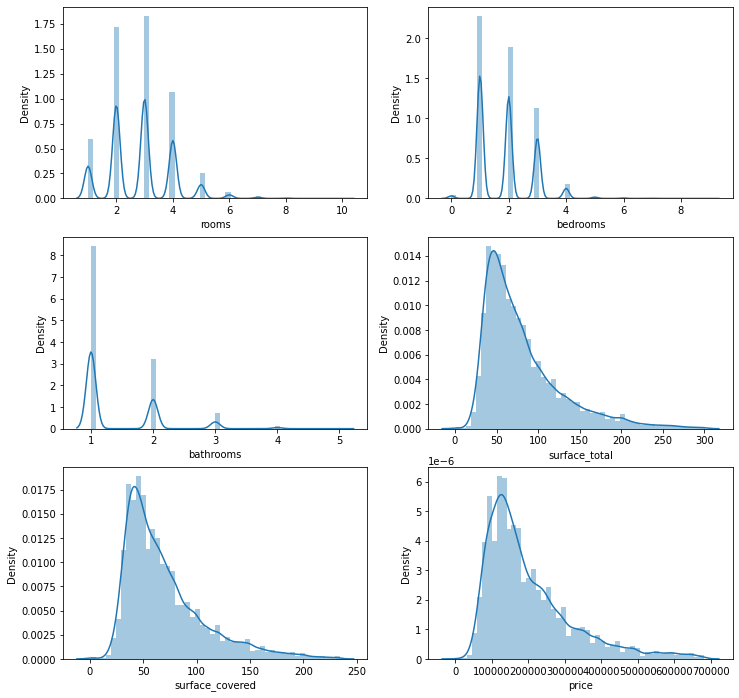

In [12]:
# Definimos la figura y la malla para la impresión
fig, axes = plt.subplots(3, 2, sharex=False, sharey=False, figsize=(12,12))
var_dist = ['rooms','bedrooms','bathrooms','surface_total','surface_covered','price']

# Definimos el ciclo para que imprima cada una de las distribuciones
for i, ax in enumerate(axes.flat):
    sns.distplot(dataP2[var_dist[i]], ax=ax)

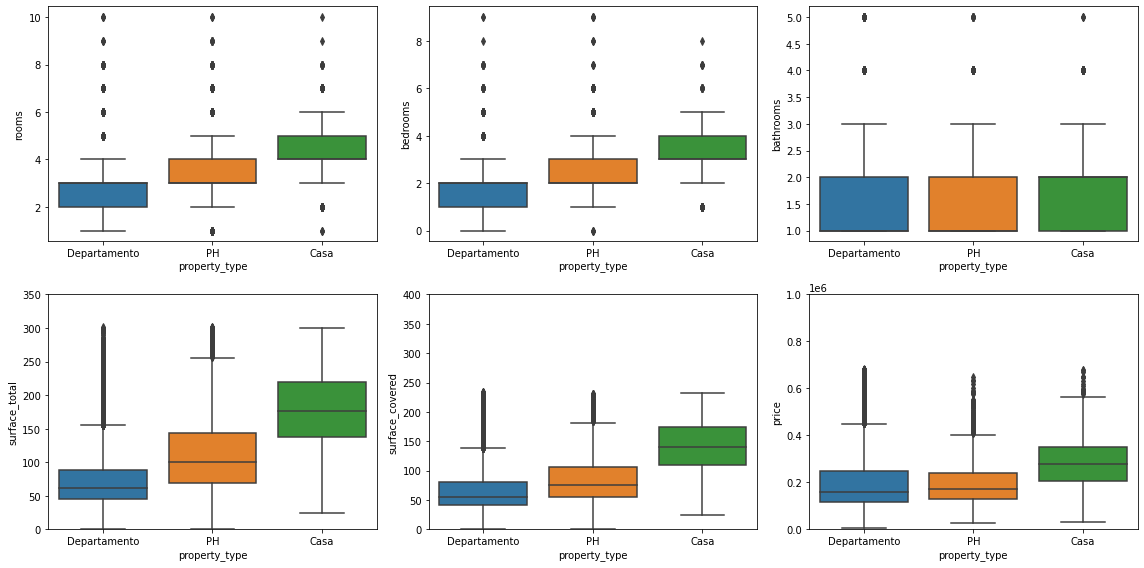

In [13]:
fig, axes = plt.subplots(2, 3, figsize=(16,8))

sns.boxplot(ax=axes[0,0], data=dataP2, x='property_type', y='rooms')

sns.boxplot(ax=axes[0,1], data=dataP2, x='property_type', y='bedrooms')

sns.boxplot(ax=axes[0,2], data=dataP2, x='property_type', y='bathrooms')

axes[1,0].set_ylim([0,350])
sns.boxplot(ax=axes[1,0], data=dataP2, x='property_type', y='surface_total')

axes[1,1].set_ylim([0,400])
sns.boxplot(ax=axes[1,1], data=dataP2, x='property_type', y='surface_covered')

axes[1,2].set_ylim([0,1000000])
sns.boxplot(ax=axes[1,2], data=dataP2, x='property_type', y='price')

plt.tight_layout()

En las gráficas se puede evidenciar que, si bien las variables no se distribuyen normalmente de manera estricta, sí se asemeja a esta distribución por lo que el <b>rango intercuartil</b> funciona bien para este fin.

### 4. Encoding

Dado que uno de los principales problemas que encontramos en el proyecto anterior con los modelos de <i>Machine Learning</i> y sus predicciones es que no tenía en cuenta si el tipo de propiedad era Departamento, PH o Casa; por lo tanto, hacer un encoding sobre "property_type" nos parece lo más adecuado para solventar este problema.

In [14]:
#data_encoded == data_dummies
data_encoded = pd.get_dummies(dataP2, columns=['l3','property_type'])
#Data set para el clusterizado
data_dummies = data_encoded.copy()
#print(data_encoded['l3'].unique().size)
data_encoded.head()

,lat,lon,l1,l2,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,...,l3_Villa Pueyrredón,l3_Villa Real,l3_Villa Riachuelo,l3_Villa Santa Rita,l3_Villa Soldati,l3_Villa Urquiza,l3_Villa del Parque,property_type_Casa,property_type_Departamento,property_type_PH
0,-34.605880,-58.384949,Argentina,Capital Federal,7.0,7.0,2.0,140.0,140.0,153000.0,...,0,0,0,0,0,0,0,0,1,0
1,-34.624056,-58.412110,Argentina,Capital Federal,2.0,1.0,2.0,70.0,58.0,159000.0,...,0,0,0,0,0,0,0,0,0,1
2,-34.593569,-58.427474,Argentina,Capital Federal,2.0,1.0,1.0,45.0,45.0,125000.0,...,0,0,0,0,0,0,0,0,0,1
3,-34.581294,-58.436754,Argentina,Capital Federal,2.0,1.0,1.0,85.0,50.0,295000.0,...,0,0,0,0,0,0,0,0,0,1
5,-34.593779,-58.441239,Argentina,Capital Federal,2.0,1.0,1.0,56.0,56.0,150000.0,...,0,0,0,0,0,0,0,0,0,1


También es pertinente hacer un <i>encoding</i> a las localidades existentes en "`l3`", sin embargo, son 57 localidades diferentes, con lo que el tamaño del dataset quedará demasiado grande, pero esto lo solventaremos proximamente haciendo un <i>Principal Components Analysis</i>

In [15]:
# Borramos las columnas que no utilizaremos 
data_encoded = data_encoded.drop(columns=['l1','l2','lat','lon'])
data_encoded

,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,l3_Abasto,l3_Agronomía,l3_Almagro,l3_Balvanera,...,l3_Villa Pueyrredón,l3_Villa Real,l3_Villa Riachuelo,l3_Villa Santa Rita,l3_Villa Soldati,l3_Villa Urquiza,l3_Villa del Parque,property_type_Casa,property_type_Departamento,property_type_PH
0,7.0,7.0,2.0,140.0,140.0,153000.0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,2.0,1.0,2.0,70.0,58.0,159000.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,2.0,1.0,1.0,45.0,45.0,125000.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,2.0,1.0,1.0,85.0,50.0,295000.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,2.0,1.0,1.0,56.0,56.0,150000.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146535,3.0,2.0,1.0,85.0,74.0,266647.0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
146536,3.0,1.0,1.0,85.0,74.0,262415.0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
146539,4.0,3.0,2.0,82.0,77.0,250000.0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
146542,2.0,1.0,1.0,80.0,80.0,170000.0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


### 5. Escalado de datos

- La bitácora dice lo siguiente: "Escalados no-lineales: muchos modelos andan mejor cuando los atributos siguen distribuciones normales. Pero este muchas veces no es el caso. A veces las distribuciones no son simétricas, sino que tienen una cola o, peor aún, siguen una ley de potencias. En esos casos, una transformación lineal como el Z-Score no servirá de mucho."
- A raiz de esto voy a transformar los valores sacandoles la raiz cuadrada y luego aplicando un escalador de datos de sklearn, pues, como vimos anteriormente, nuestra dibución tiene una cola hacia la derecha.

In [16]:
# Transformo los datos a log y sqrt
# cambio el nombre del dataset
escalables = ['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered',
       'price']
dfesc = data_encoded.copy()
dfesc = dfesc[escalables]

# paso el valor a raiz cuadrada
for col in escalables:
    dfesc[f'{col}_sqrt'] = np.sqrt(dfesc[col])
print('done')

done


In [17]:
# Usare solamente los datos transofrmados con su raiz cuadrada
# voy a quitar el target precio para no escalarlo
ds = dfesc.iloc[:, -6:]
y = data_encoded['price']
ds = ds.drop(columns='price_sqrt')
ds.head()

,rooms_sqrt,bedrooms_sqrt,bathrooms_sqrt,surface_total_sqrt,surface_covered_sqrt
0,2.645751,2.645751,1.414214,11.832160,11.832160
1,1.414214,1.000000,1.414214,8.366600,7.615773
2,1.414214,1.000000,1.000000,6.708204,6.708204
3,1.414214,1.000000,1.000000,9.219544,7.071068
5,1.414214,1.000000,1.000000,7.483315,7.483315


In [18]:
# Escalo los datos
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
# al parecer standard scaler cambia la relacion en la medida de los datos
'''
# scaler logaritmos
columnas = dfesc_log.columns
scaler = StandardScaler().fit(dfesc_log)
df_escal_log = scaler.transform(dfesc_log)
df_escal_log = pd.DataFrame(df_escal_log, columns=columnas)
'''
#scaler raiz cuadrad
columnas2 = ds.columns
scaler2 = MinMaxScaler()
df_escal_sqrt = scaler2.fit_transform(ds)
df_escal_sqrt = pd.DataFrame(df_escal_sqrt, columns=columnas2)

'''
# grafico, las distribuciones se ven normales en la mayoria de atributos
for x in columnas2:
    sns.displot(data=df_escal_sqrt[x], bins=10)
'''
z = 0

In [19]:
# Combino el df escalado con el encoding del tipo de propiedad
df_escalado = df_escal_sqrt.reset_index().drop(columns='index').join(data_encoded.iloc[:,-60:].reset_index().drop(columns='index'))
columnas_esc = df_escalado.columns
df_escalado.head()

,rooms_sqrt,bedrooms_sqrt,bathrooms_sqrt,surface_total_sqrt,surface_covered_sqrt,l3_Abasto,l3_Agronomía,l3_Almagro,l3_Balvanera,l3_Barracas,...,l3_Villa Pueyrredón,l3_Villa Real,l3_Villa Riachuelo,l3_Villa Santa Rita,l3_Villa Soldati,l3_Villa Urquiza,l3_Villa del Parque,property_type_Casa,property_type_Departamento,property_type_PH
0,0.761119,0.881917,0.335106,0.662544,0.757650,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0.191564,0.333333,0.335106,0.450574,0.462737,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0.191564,0.333333,0.000000,0.349139,0.399257,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0.191564,0.333333,0.000000,0.502744,0.424638,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0.191564,0.333333,0.000000,0.396549,0.453472,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


### 1.6. Principal Component Analysis

In [20]:
## Principal Component Analysis
from sklearn.decomposition import PCA
from prettytable import PrettyTable

# Loop Function to identify number of principal components that explain at least 85% of the variance
for comp in range(3, df_escalado.shape[1]):
    pca = PCA(n_components= comp, random_state=42)
    pca.fit(df_escalado)
    comp_check = pca.explained_variance_ratio_
    final_comp = comp
    if comp_check.sum() > 0.75:
        break
        
print("El número de componentes con el que se alcanza a explicar el 75% de la varianza del dataset es de {} componentes".format(final_comp))


El número de componentes con el que se alcanza a explicar el 75% de la varianza del dataset es de 18 componentes


Elegimos la cantidad de componentes que expliquen el 75% de la varianza del dataset para que más adelante no sea tan pesado correr los modelos, pues vamos a trabajar con Atributos Polinómicos más adelante.

In [21]:
# Definimos el PCA con la cantidad de componentes determinada en el ciclo
pca = PCA(n_components=final_comp)
# Entrenamos el PCA y transformamos el dataset
data = pca.fit_transform(df_escalado)
df_pca = pd.DataFrame(data)

# Se describen los Componentes Principales según sus valores propios
pcaCC = abs(pca.components_) 

# Ciclo para describir cada uno de los Componentes Principales
for a in range(len(pcaCC)):
    pcaMax = sorted(zip(pcaCC[a], df_escalado.columns), reverse=True)[:3]
    # Creamos la tabla que explica cada Componente Principal
    pcaMaxTable = PrettyTable()
    pcaMaxTable.field_names = ['Atributo','Valor']
    for b in range(len(pcaMax)):
        valPca = pcaMax[b][0]
        pcaMaxTable.add_row([pcaMax[b][1],valPca])
        
    print()
    print("Las variables más importantes (que tienen mayor valor) del PC{} son:".format(a+1))
    print()
    print(pcaMaxTable)


Las variables más importantes (que tienen mayor valor) del PC1 son:

+----------------------------+---------------------+
|          Atributo          |        Valor        |
+----------------------------+---------------------+
| property_type_Departamento |  0.720099082977945  |
|      property_type_PH      |  0.6352964239408092 |
|     surface_total_sqrt     | 0.13413616263468672 |
+----------------------------+---------------------+

Las variables más importantes (que tienen mayor valor) del PC2 son:

+--------------+---------------------+
|   Atributo   |        Valor        |
+--------------+---------------------+
|  l3_Palermo  |  0.9454211508983033 |
| l3_Belgrano  | 0.22328427744844262 |
| l3_Caballito | 0.16292198239380892 |
+--------------+---------------------+

Las variables más importantes (que tienen mayor valor) del PC3 son:

+----------------------+--------------------+
|       Atributo       |       Valor        |
+----------------------+--------------------+
|    bat

In [22]:
# Determinamos la importancia de cada uno de los componentes en el análisis 
pcaExplained = abs(pca.explained_variance_ratio_)*100

# Creamos una tabla para mostrar la importancia de cada componente
pcaEVR = PrettyTable()
pcaEVR.field_names = ['PC', 'Importancia[%]']
for a in range(len(pcaExplained)):
    pcaEVR.add_row([a+1,pcaExplained[a]])

print(pcaEVR)

+----+--------------------+
| PC |   Importancia[%]   |
+----+--------------------+
| 1  | 17.641998718431477 |
| 2  | 8.170047603457517  |
| 3  | 6.925000465653305  |
| 4  | 5.953011168174099  |
| 5  | 5.429943400563722  |
| 6  | 4.228675048776829  |
| 7  | 3.705477592985709  |
| 8  | 3.417916286841834  |
| 9  | 3.0092794891341623 |
| 10 | 2.7047262194788613 |
| 11 | 2.5210391236570198 |
| 12 |  2.42423987808212  |
| 13 | 2.251950206973506  |
| 14 | 1.8369408522768367 |
| 15 | 1.6267307517337355 |
| 16 | 1.493638347829707  |
| 17 | 1.309538027298363  |
| 18 | 1.2642213939067968 |
+----+--------------------+


Siendo el primer componente el que tiene un mayor porcentaje de participación en la explicación de la varianza del dataset, es importante notar que este está compuesto por:
* El tipo de propiedad 'Departamento'
* El tipo de propiedad 'PH'
* La superficie total de la propiedad

Notando así la importancia haber hecho el encoding al tipo de propiedad y el cuál era una de las principales falencias de los modelos presentados en el Proyecto 01. También es importante resaltar que en este componente no se toma en cuenta el tipo de propiedad 'Casa', probablemente por su baja participación en todo el dataset, pues únicamente aparece hasta el componente 10.

Para el componente número dos, notamos que está compuesto por localidades de Palermo, Belgrano y Caballito, que sabemos del primer Proyecto que son de las más abundantes en la Capital Federal, por lo que tiene sentido que sean importantes al tratar de de agrupar el dataset

Al ver las variables que componen los <i>Principal Components</i> y la importancia de cada uno de estos, decidimos que seguiremos trabajando con este nuevo dataset debido a que contiene la combinación lineal de muchas variables diferentes y las cuales todas tienen sentido en el análisis.

#### Comparación con el modelo de árbol del Proyecto 01

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Definimos la porción de entramiento y la de testeo
X_train, X_test, y_train, y_test = train_test_split(
            df_pca, y, test_size=0.3, random_state=42)

In [24]:
from sklearn.tree import DecisionTreeRegressor

# Creamos el modelo de árbol de decisión y lo entrenamos con el conjunto de entreno
tree = DecisionTreeRegressor(max_depth=8, random_state=42)
tree.fit(X_train, y_train)

# Predecimos para cada uno de los conjuntos
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

In [25]:
# Evaluamos el error con la Raíz del Error Cuadrático Medio (RMSE)
rmseTreeTrain2 = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmseTreeTest2 = np.sqrt(mean_squared_error(y_test, y_test_pred))

# Definimos el mismo indicador con los valores del Proyecto 01

rmseTreeTrain1 = 133544.03
rmseTreeTest1 = 151031.64

rmse12 = PrettyTable()
rmse12.field_names = ['RMSE','Proyecto 01', 'Proyecto 02']
rmse12.add_row(['Train', rmseTreeTrain1,rmseTreeTrain2])
rmse12.add_row(['Test' ,rmseTreeTest1,rmseTreeTest2])

print(rmse12)

+-------+-------------+--------------------+
|  RMSE | Proyecto 01 |    Proyecto 02     |
+-------+-------------+--------------------+
| Train |  133544.03  | 56562.008647335206 |
|  Test |  151031.64  | 60160.41402489578  |
+-------+-------------+--------------------+


Vemos que existe una mejora sustancial entre los resultados del RMSE de cada árbol entre cada proyecto, siendo, en el Proyecto 02, alrededor de la mitad del error que en el Proyecto 1.
Esta mejora se debe seguramente a la mejore utilizacion de los datos, por medio del escalado, tambien por el encoding del tipo de propiedad que en el proyecto anterior faltaba.

## PARTE B: Modelos Complejos

## 1. Random Forest

### 1.1 Comparacion del mejor modelo anterior de arbol con un modelo de random forest default

In [26]:
# separado de datos
X_train, X_test, y_train, y_test = train_test_split(
            df_pca, y, test_size=0.33, random_state=42)

In [27]:
# Entrenar el mejor modelo de arbol del proyecto anterior
from sklearn.tree import DecisionTreeRegressor
modelo_anterior = DecisionTreeRegressor(max_depth=15).fit(X_train, y_train)
pred_modelo_viejo = modelo_anterior.predict(X_test)
rmse_tree_old_test = np.sqrt(mean_squared_error(y_test, pred_modelo_viejo))
rmse_tree_old_test

58172.68878742272

In [28]:
## Creacion modelo Random forest sin optimizar
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(random_state=42, n_jobs=-1).fit(X_train, y_train)
y_pred_train = forest.predict(X_train)
y_pred_test = forest.predict(X_test)

In [29]:
# resultados modelo random forest con argumentos defaults
rmse_train_forest = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test_forest = np.sqrt(mean_squared_error(y_test, y_pred_test))
rmse_test_forest, rmse_train_forest

(48053.982693130914, 22325.976119102)

In [30]:
# comparacion en tabla
tab1 = PrettyTable()
tab1.field_names = ['Modelo','# Proyecto', 'RMSE']
tab1.add_row(['Decision Tree Optimizado', 1,rmse_tree_old_test])
tab1.add_row(['Random Forest Default' ,2,rmse_test_forest])
print(tab1)

+--------------------------+------------+--------------------+
|          Modelo          | # Proyecto |        RMSE        |
+--------------------------+------------+--------------------+
| Decision Tree Optimizado |     1      | 58172.68878742272  |
|  Random Forest Default   |     2      | 48053.982693130914 |
+--------------------------+------------+--------------------+


Conclucion:
El modelo de ensamblaje es superior al modelo de Decision Tree optimizado del anterior proyecto, incluso cuando el modelo de ensamblaje tiene argumentos default.

### 1.2. Optimizacion modelo RandomForest con RandomSearch

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV


# Grilla para random Search
param_grid = {
              'n_estimators':sp.stats.randint(100, 300),
              'criterion':['mse', 'mae'],
              'max_features':['auto', 'sqrt', 'log2']
             }
forest2 = RandomForestRegressor()
model = RandomizedSearchCV(forest2, n_iter=3, param_distributions=param_grid, cv=3, n_jobs=-1)
model.fit(df_pca, y)

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=3, n_jobs=-1,
                   param_distributions={'criterion': ['mse', 'mae'],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f6d3484d730>})

In [32]:
print("Mejores parametros: "+str(model.best_params_))
print("Mejor Score: "+str(model.best_score_)+'\n')
scores = pd.DataFrame(model.cv_results_)
#scores

Mejores parametros: {'criterion': 'mae', 'max_features': 'auto', 'n_estimators': 249}
Mejor Score: 0.8318382072058479



In [ ]:
# Entrenar modelo con los mejores parametros
mejor_modelo = RandomForestRegressor(criterion= 'mae', max_features = 'auto', n_estimators = 249, n_jobs=-1)
mejor_modelo.fit(X_train, y_train)
y_pred_test = mejor_modelo.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred_test))

In [ ]:
from sklearn.tree import export_graphviz
from IPython.display import Image
from subprocess import call
from sklearn import tree

In [1]:
# Export as dot file
#mejor_modelo.decision_path(X_train)
for i, tree_regressor in enumerate(mejor_modelo.estimators_):
    ## exportamos solo el primer arbol
    if i == 0: 
        plt.figure(figsize = (10,8))
        tree.plot_tree(tree_regressor, filled = True)
        plt.show()
        ## exportar el arbol en .dot
        export_graphviz(tree, out_file='tree.dot', 
                    feature_names = X_test.columns,
                    rounded = True, proportion = False, 
                    precision = 2, filled = True)
    else:
        break

NameError: name 'mejor_modelo' is not defined

### 1.3 Conclusiones parciales del arbol
Al exportar el primer arbol de decision del modelo de random forest optimizado podemos ver varias cosas. Los primeros nodos del usan el label 2 para separar los datos. Se usa en 3 nodos. Este "label 2" se refiere al atributo 3 del pca. Este atributo contiene el numero de habitaciones, la superficie cubierta y la cantidad de baños.
Parece entonces que para hacer una regresion para saber que precio tiene una propiedad 

## 2. Regresion

### 2.1 Regresión con atributos polinómicos y regularización

Primero realizamos una regresión lineal sencilla para tener este modelo como benchmark

In [34]:
from sklearn.linear_model import LinearRegression
reg1 = LinearRegression()
reg1.fit(X_train, y_train)

LinearRegression()

In [35]:
""" Función para evaluar el un modelo de regresión, que toma como entrada:
model: variable con el modelo definido
X_train: La matriz de atributos de entrenamiento
X_test: La matriz de atributos de ensayo
y_train: La matriz de etiquetas correspondientes al set de entrenamiento
y_test: La matriz de etiquetas correspondientes al set de ensayo   
Y devuelve:
RMSE tanto para el set de entrenamiento como de ensayo
r2 tanto para el set de entrenamiento como de ensayo
Gráfica de distribución de los errores en cada set
Gráfica de ajuste a la regresión """

def evaluar_modelo(model, X_train, X_test, y_train, y_test):
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    ### CALCULAMOS EL ERROR
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)

    print(f'Raíz del error cuadrático medio en Train: {rmse_train}')
    print(f'Raíz del error cuadrático medio en Test: {rmse_test}')
    print(f'R2 en Train: {r2_train}')
    print(f'R2 en Test: {r2_test}')
    
    plt.figure(figsize = (12,4))
    plt.subplot(1,2,1)

    plt.subplot(1,3,2)
    sns.distplot(y_train - y_train_pred, bins = 20, label = 'train')
    sns.distplot(y_test - y_test_pred, bins = 20, label = 'test')
    plt.xlabel('errores')
    plt.legend()
    plt.xticks(rotation=0)

    ax = plt.subplot(1,3,3)
    ax.scatter(y_test,y_test_pred, s =2)

    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes]
    ]

    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.xlabel('y (test)')
    plt.ylabel('y_pred (test)')

    plt.tight_layout()
    plt.show()
    
    return rmse_train, rmse_test, r2_train, r2_test

Raíz del error cuadrático medio en Train: 67829.25184131082
Raíz del error cuadrático medio en Test: 67023.4522735587
R2 en Train: 0.6737390622888406
R2 en Test: 0.6805459533151973


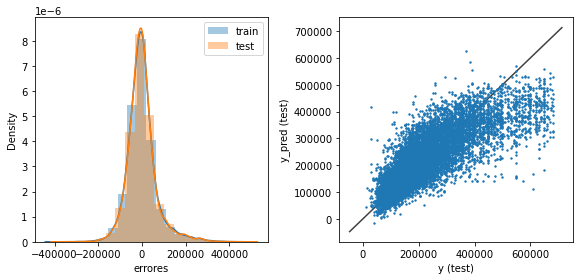

In [36]:
rmse_train_reg1, rmse_test_reg1, r2_train_reg1, r2_test_reg1 = evaluar_modelo(reg1, X_train, X_test, y_train, y_test)

In [37]:
reg1.coef_

array([ 20819.50932223,  28712.00508363, 304343.23574971,  52318.19554272,
        -9461.71356198, -12191.78976278,  37142.46752337, -25939.59890346,
        56732.24378834, -66552.52003908,   4957.16144377, -11953.74884831,
        53705.18311152,  13550.47262304,   9206.55044885,  20398.61361047,
        42065.04468823,  17063.71245208])

In [38]:
rmse_train_reg1

67829.25184131082

In [39]:
reg1_intercept = reg1.intercept_
print(reg1_intercept)

200891.10309700668


### 2.2 Atributos Polinómicos

Iniciaremos con atributos polinómicos de grado <b>3</b>, luego implementaremos los modelos de regularización con sus hiperparámetros por defecto para finalmente hacer un Grid Search con Cross Validation con los modelos.

In [40]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2, include_bias=False)
X_train_new = poly.fit_transform(X_train)
X_test_new = poly.fit_transform(X_test)
print(X_train_new.shape, X_test_new.shape)

(31873, 189) (15700, 189)


Notamos que se agregaron 136 columnas, es decir, 8 por atributo.

### 2.3 Ridge y Lasso

Utilizaremos la función de ScikitLearn que ya tiene integrado el Cross Validation dentro de Ridge y Lasso: <b>RidgeCV y LassoCV</b>

Raíz del error cuadrático medio en Train: 58416.15302585169
Raíz del error cuadrático medio en Test: 58317.928354458934
R2 en Train: 0.7580102711119515
R2 en Test: 0.7581428214805703


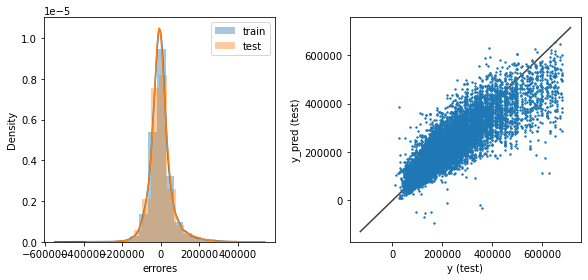

Raíz del error cuadrático medio en Train: 63926.636676576905
Raíz del error cuadrático medio en Test: 63490.28864793732
R2 en Train: 0.7102024309447673
R2 en Test: 0.7133384735225483


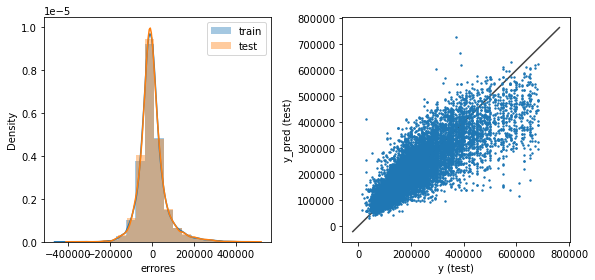

In [41]:
# Importamos los modelos
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV

# Modelo de regresión Ridge con Cross Validation
ridge_reg1 = RidgeCV().fit(X_train_new, y_train)
# Modelo de regresión Lasso con Cross Validation
lasso_reg1 = LassoCV(max_iter=10000).fit(X_train_new, y_train)

# Evaluamos los modelos con la función ya definida
rmse_train_ridge, rmse_test_ridge, r2_train_ridge, r2_test_ridge = evaluar_modelo(ridge_reg1,
                                                                                  X_train_new, X_test_new, y_train, y_test)

rmse_train_lasso, rmse_test_lasso, r2_train_lasso, r2_test_lasso = evaluar_modelo(lasso_reg1,
                                                                                  X_train_new, X_test_new, y_train, y_test)

Notamos que los resultados del error no son muy diferentes en comparación con el modelo de regresión lineal de benchmark que teníamos inicialmente, pero existen ligeras mejoras en comparación. Procedemos a mirar los coeficientes e interceptos con la regularización realizada

In [42]:
# El valor de alpha utilizado por la regresión Ridge
print(f"El valor de alpha utilizado por la regresión Ridge fue de {ridge_reg1.alpha_}")

El valor de alpha utilizado por la regresión Ridge fue de 0.1


In [43]:
np.set_printoptions(suppress=True)

# Los coeficientes de la regresión Ridge
ridge1_coef = ridge_reg1.coef_
print(ridge1_coef)

[ -790665.78542216    90380.55602114   822646.08225387   487708.99021829
 -1071628.35300589   258097.01539659  1027070.77186633   -23652.0011698
  -283311.57097111  1556679.28789689  -912988.91778825 -1049129.71728869
  1036090.64262016 -1246907.98590746   101080.01764638   380766.97412637
    98341.40639485   -81762.95848528   816763.65183691    98765.66136161
  -664785.58429761  -166927.98462193    41990.39727686   432036.01430686
  -110423.74306178  -191614.95831178   348617.23380836  -942749.85177358
   701208.65729114   456224.30386173    57546.60056278    -6128.48324825
    14368.85559795   -16554.74786529    21150.23433281    -1098.02423876
   -31648.0111747    374080.14582448   -79989.02436679  -557973.87585472
  1042865.70394291   258907.65741517     -935.69492041    63400.97145455
  -124521.9808647    -23697.51449878  -485527.30497752   356017.80126154
  -126288.66745656    22115.46101155   -96071.6406321    -78089.92373159
    62182.42224169   334178.13289032  -601200.414456

In [44]:
ridge1_intercept = ridge_reg1.intercept_
print(ridge1_intercept)

-117517.64064511866


In [45]:
# El valor de alpha utilizado por la regresión Lasso
print(f"El valor de alpha utilizado por la regresión Lasso fue de {lasso_reg1.alpha_}")

El valor de alpha utilizado por la regresión Lasso fue de 28.115076701944936


In [46]:
# Coeficientes de la regresión Lasso
lasso1_coef = lasso_reg1.coef_
print(f'Los coeficientes de la regresión Lasso son: {lasso1_coef}')

Los coeficientes de la regresión Lasso son: [  22046.26570957   26492.22399326  318285.29513479   52967.78993481
      -0.          -11927.57758508   49745.20643352       0.
       0.           27878.63552776  -51345.2999571   -54969.09434518
       0.          -46559.35789091    8248.4727309    -6955.78169623
    1059.04648049   40358.65180538       0.            5995.8329405
  -66011.62495767  -23088.42138951    8294.64460063   27190.21006311
   -3637.0855289   -13471.02840076   31531.54232068  -24570.13047349
   18747.1734649      203.32532417      -0.               0.
      -0.           12566.44106271   -2656.68079923       0.
   11645.56799466   62405.46339509      -0.              -0.
       0.              -0.              -0.               0.
  -20424.31314306       0.               0.               0.
      -0.              -0.              -0.              -0.
      -0.          101183.4127747       -0.               0.
   68159.95274441   59067.64385183  -26563.86275888   1

In [47]:
lasso1_intercept = lasso_reg1.intercept_
print(f'El intercepto para la regresión Lasso es: {lasso1_intercept}')

El intercepto para la regresión Lasso es: 182378.05758295348


Notamos que en el caso de la regresión Lasso aparecen muchos coeficientes con valor de cero, lo cuál podría significar que se están utilizando más atributos que los que en realidad necesitaría el modelo. Sin embargo, también notamos que el valor de <i><b>alpha</b></i> es demasiado alto en comparación con el que se utilizó por defecto en Ridge, lo cuál es extraño pues los valores de <i><b>alpha</b></i> para Lasso suelen ser de menor orden de magnitud que para Ridge.

### 2.4 Grid Search con Cross Validation

Habiendo agregado los atributos, procedemos a hacer un grid search para los modelos de Lasso y Ridge. Para ambos, elegimos el rango de definido de [1, 0.1, 0.01, 0.001, 0.0001, 0] debido a que en los modelos anteriores corrido con Cross Validation, para el caso de Ridge, tomó un valor muy cercano a cero el valor de alpha, y lo más usual es que el valor de alpha para Lasso sea menor que el de Ridge, entonces consideramos que es un buen rango de valores para que además el <i>Grid Search</i> no se demore demasiado. 

In [48]:
# Importamos los modelos
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

# Definimos los modelos
ridge_reg2 = Ridge()
lasso_reg2 = Lasso()

#Definimos las métricas de error
scoringGS = ['neg_root_mean_squared_error', 'r2']

Raíz del error cuadrático medio en Train: 51748.543473073885
Raíz del error cuadrático medio en Test: 52309.30323155194
R2 en Train: 0.81009898432971
R2 en Test: 0.8054135134614274


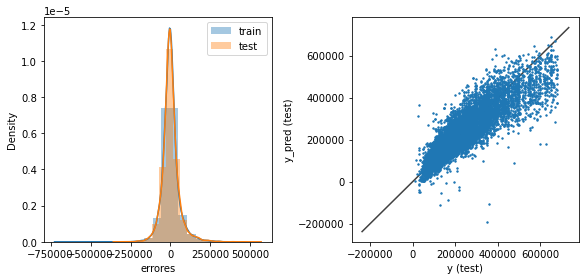

(51748.543473073885, 52309.30323155194, 0.81009898432971, 0.8054135134614274)

In [49]:
# Importamos el Grid Search con Cross Validation
from sklearn.model_selection import GridSearchCV

# Definimos el modelo para la regresión Ridge
paramsR_GS = {'alpha': [1,0.1,0.01,0.001,0.0001,0] , "fit_intercept": [True, False], "solver": ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}
ridge_GS = GridSearchCV(ridge_reg2, param_grid=paramsR_GS, n_jobs=-1, scoring=scoringGS, refit='neg_root_mean_squared_error')
ridge_GS.fit(X_train_new,y_train)

evaluar_modelo(ridge_GS, X_train_new, X_test_new, y_train, y_test)

In [50]:
# Resultados

# Valor de alpha encontrado por Grid Search and CV
alphaRidge = ridge_GS.best_params_['alpha']
print(f'El mejor valor de alpha encontrado fue de: {alphaRidge}')
print()

# El mejor valor de RMSE encontrado
rmse_train_ridgeGS = ridge_GS.best_score_
print(f'El mejor valor de RMSE encontrado fue de: {rmse_train_ridgeGS}')
print()

# El mejor valor de r2 encontrado
r2_train_ridgeGS = np.min(abs((ridge_GS.cv_results_['mean_test_r2'])))
print(f'El mejor valor de r2 encontrado fue: {r2_train_ridgeGS}')
print()

# Los coeficientes correspondientes a la regresión
coefRidge = ridge_GS.best_estimator_.coef_
print(f'Los coeficientes asociados a la regresión son: {coefRidge}')
print()

# La intercepción de la regresión
ridgeGS_intercept = ridge_GS.best_estimator_.intercept_
print(f'La intercepción de la regresión es: {ridgeGS_intercept}')


El mejor valor de alpha encontrado fue de: 0

El mejor valor de RMSE encontrado fue de: -53117.03760659309

El mejor valor de r2 encontrado fue: 0.7332347501293581

Los coeficientes asociados a la regresión son: [ 9.55971287e+14 -8.69007110e+16 -1.20532635e+16  6.56523307e+16
  8.74016625e+16  1.01668398e+17  8.68390248e+16 -3.74539959e+16
  1.17620348e+17  1.11044634e+17 -6.72884869e+16  2.08504794e+17
  1.07084834e+16 -1.03712394e+17 -3.74607745e+15 -2.07747695e+16
 -8.73926653e+16  3.37282118e+17  2.32068862e+15 -1.31928610e+16
 -4.74444083e+15  1.33938855e+16 -7.64466356e+16 -5.82912242e+16
  8.20534858e+16  1.26351376e+17 -7.78727326e+16 -9.65939474e+16
  9.33689968e+16 -1.78331473e+17 -8.79262686e+16  1.11354858e+17
  9.36706163e+16  4.24122481e+16  5.00588451e+16 -2.06413878e+17
 -4.85659398e+16 -2.34304479e+17  9.63974132e+16  1.85305099e+18
 -2.69799982e+16 -5.50308746e+17 -4.90977011e+17  1.01865181e+18
  1.40248933e+17 -1.78437858e+18  1.64742205e+18  1.27129418e+18
 -2.4020

Ahora, haremos una relación entre los coeficientes de 

In [51]:
fff = (ridge_reg1.coef_ / coefRidge)*100

In [52]:
abs(fff).std()

6.650515473799312e-09

Obtenemos entonces que el mejor valor de <b>alpha</b> para la regresión Ridge es `0.0001`, lo cual quiere decir que obtenemos casi el mismo resultado que con una regresión lineal sin penalización

In [53]:
# Predecimos con el modelo las instancias se quedaron por fuera del set de entramiento
y_test_predGS = ridge_GS.predict(X_test_new)

In [54]:
rmse_test_ridgeGS = np.sqrt(mean_squared_error(y_test, y_test_predGS))
rmse_test_ridgeGS 

52309.30323155194

In [55]:
r2_test_ridgeGS = r2_score(y_test, y_test_predGS)
r2_test_ridgeGS

0.8054135134614274

Ahora, realizaremos el Grid Search para Lasso

In [56]:
from sklearn.model_selection import GridSearchCV
paramsL_GS = {'alpha': [1,0.1,0.01,0.001,0.0001,0] , 'fit_intercept': [True, False], 'selection': ['cyclic', 'random']}
lasso_GS = GridSearchCV(lasso_reg2, param_grid=paramsL_GS, n_jobs=-1, scoring=scoringGS, refit='neg_root_mean_squared_error')
lasso_GS.fit(X_train_new,y_train)

/home/sakito/anaconda3/envs/datasc/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 50343818546735.58, tolerance: 173882848303.8091
  model = cd_fast.enet_coordinate_descent(


GridSearchCV(estimator=Lasso(), n_jobs=-1,
             param_grid={'alpha': [1, 0.1, 0.01, 0.001, 0.0001, 0],
                         'fit_intercept': [True, False],
                         'selection': ['cyclic', 'random']},
             refit='neg_root_mean_squared_error',
             scoring=['neg_root_mean_squared_error', 'r2'])

Raíz del error cuadrático medio en Train: 59043.088911753315
Raíz del error cuadrático medio en Test: 58990.75676224521
R2 en Train: 0.7527882172167916
R2 en Test: 0.7525298957885564


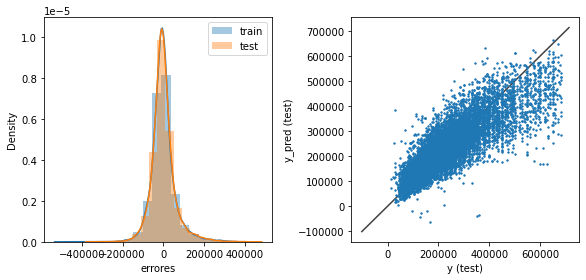

(59043.088911753315, 58990.75676224521, 0.7527882172167916, 0.7525298957885564)

In [57]:
evaluar_modelo(lasso_GS, X_train_new, X_test_new, y_train, y_test)

In [58]:
# Resultados

# Valor de alpha encontrado por Grid Search and CV
alphaLasso = lasso_GS.best_params_['alpha']
print(f'El mejor valor de alpha encontrado fue de: {alphaLasso}')
print()

# El mejor valor de RMSE encontrado
rmse_train_lassoGS = lasso_GS.best_score_
print(f'El mejor valor de RMSE encontrado fue de: {rmse_train_lassoGS}')
print()

# El mejor valor de r2 encontrado
r2_train_lassoGS = np.min(abs((lasso_GS.cv_results_['mean_test_r2'])))
print(f'El mejor valor de r2 encontrado fue: {r2_train_lassoGS}')
print()

# Los coeficientes correspondientes a la regresión
coefLasso = lasso_GS.best_estimator_.coef_
print(f'Los coeficientes asociados a la regresión son: {coefLasso}')
print()

# La intercepción de la regresión
lassoGS_intercept = lasso_GS.best_estimator_.intercept_
print(f'La intercepción de la regresión es: {lassoGS_intercept}')


El mejor valor de alpha encontrado fue de: 1

El mejor valor de RMSE encontrado fue de: -59552.11943678983

El mejor valor de r2 encontrado fue: 0.7450374274988889

Los coeficientes asociados a la regresión son: [ -147338.02627178    38054.40809692   573737.4170806    222196.44258599
  -315001.59987975  -196734.84474985   441142.87446324   175137.08840038
  -317878.16115951  1436853.96754779  -996318.84106007  -775569.11164788
   823216.77034458 -1451221.57140212   140904.22491747   291367.31234672
   206621.98371762  -123340.81605816   290813.38512255    69615.97519666
  -366904.5278686   -114006.19159012   185001.65020814   262513.96714287
   -95138.71266084  -165436.23967901   322019.51280584  -638521.98984626
   528654.94686861   483945.57976489  -222026.71989849   161107.16912352
    26023.53555918   -66787.65087028   -17366.49298673   -16389.91791338
   246599.73690021   273314.83849242        0.         -1050095.82051456
   701685.57053179   264592.88746835       -0.            

In [59]:
lasso_GS.best_params_

{'alpha': 1, 'fit_intercept': False, 'selection': 'cyclic'}

Ahora, predecimos el conjunto de test 

In [60]:
y_test_predGS = lasso_GS.predict(X_test_new)

In [61]:
rmse_test_lassoGS = np.sqrt(mean_squared_error(y_test, y_test_predGS))
rmse_test_lassoGS

58990.75676224521

In [62]:
r2_test_lassoGS = r2_score(y_test, y_test_predGS)
r2_test_lassoGS

0.7525298957885564

### 2.5 Regresión lineal con Atributos Polinómicos y Cross Validation

In [63]:
from sklearn.linear_model import LinearRegression
reg11 = LinearRegression()
reg11.fit(X_train_new, y_train)

LinearRegression()

In [64]:
from sklearn.model_selection import cross_validate

reg1_scores = cross_validate(reg11, X_train_new, y_train, cv=7, scoring=scoringGS)

In [65]:
scoringGS

['neg_root_mean_squared_error', 'r2']

In [66]:
print(reg1_scores)

{'fit_time': array([0.17391109, 0.14113188, 0.12759829, 0.14540839, 0.14713287,
       0.14394689, 0.13631701]), 'score_time': array([0.00250316, 0.00212169, 0.00227952, 0.00200701, 0.0025456 ,
       0.00227141, 0.00203586]), 'test_neg_root_mean_squared_error': array([-56653.09419255, -51795.25884293, -57518.35418082, -51932.95813331,
       -52578.29391437, -52190.09117572, -49132.5548824 ]), 'test_r2': array([0.77592133, 0.80593148, 0.76814252, 0.8085888 , 0.80537619,
       0.80601384, 0.82693038])}


In [67]:
rmse_train_reg2 = abs(reg1_scores['test_neg_root_mean_squared_error']).mean()
rmse_train_reg2

53114.372188871246

In [68]:
r2_train_reg2 = abs(reg1_scores['test_r2']).mean()
r2_train_reg2

0.7995577931441534

In [69]:
np.set_printoptions(suppress=True)

reg11_coef = reg11.coef_
print(reg11_coef)

[-8.07049849e+12  2.32778738e+16 -1.35772878e+16  8.97350629e+16
  7.08720000e+16  2.54977226e+16  7.28838232e+16  2.52866093e+16
 -5.69003888e+16 -2.69656069e+16 -1.93846308e+16  1.97680149e+16
 -8.02685209e+15 -4.40881657e+15 -6.35548134e+15 -1.73171345e+15
 -3.09184452e+15  9.81224984e+15 -4.35227372e+14  2.24254617e+15
  6.61507914e+15 -6.03079010e+16 -5.38999356e+16 -2.92227804e+16
 -5.11147485e+16 -9.79040525e+15  5.16107578e+16  1.27071818e+16
  1.64756576e+16 -3.03670798e+16 -1.18299032e+15  9.73460550e+15
  7.19751855e+15  1.85636534e+15  1.80016952e+15 -9.95160888e+15
 -1.60077402e+17 -6.20492065e+16  1.05159191e+18  1.32513522e+18
  6.33036971e+17  5.72903107e+17 -2.41788911e+17 -6.48651056e+17
 -1.55881762e+17 -3.55413833e+17  2.62963448e+17 -1.46641531e+17
 -2.99309072e+17  8.26059340e+16 -2.04338286e+17 -4.60019574e+16
  1.94100729e+17  1.45814312e+16 -8.53214005e+16 -3.94872569e+16
  4.33572410e+16  8.49013968e+16  9.25877185e+16 -1.24248526e+17
  2.67979107e+16  2.47598

In [70]:
reg11_intercept = reg11.intercept_
print(reg11_intercept)

1081638709578780.0


Podemos observar que el error sobre el conjunto de train dio el mismo que haciéndolo con Ridge y Grid Search

Ahora, debido a que el cross validation únicamente fue hecho con el conjunto de train, juntaré ambos datasets (train y test) para correrlos en conjunto con el cross validation y ver el resultado.

In [71]:
# Unimos ambos conjuntos de atributos
X_new = np.concatenate((X_train_new, X_test_new))

In [72]:
# Unimos ambos conjuntos de etiquetas
y_new = np.concatenate((y_train,y_test))

In [73]:
# Realizamos una regresión lineal sobre los conjuntos unidos
reg2_scores = cross_validate(reg1, X_new, y_new, cv=5, scoring=scoringGS)

In [74]:
rmse_test_reg2 = reg2_scores['test_neg_root_mean_squared_error'].mean()
rmse_test_reg2

-52512.46207494001

In [75]:
r2_test_reg2 = reg2_scores['test_r2'].mean()
r2_test_reg2

0.8040992319118171

Finalmente, en los próximos datasets, se muestra en resumen de los errores obtenidos con las diferentes variaciones de regresiones realizadas.

In [76]:
# Resultados para training

results_models_train = [['Reg Lineal sin AP', abs(rmse_train_reg1) , abs(r2_train_reg1)],
['Reg Lineal con AP', abs(rmse_train_reg2) , abs(r2_train_reg2)],
['Reg Lineal Ridge', abs(rmse_train_ridge) , abs(r2_train_ridge)],
['Reg Lineal Lasso', abs(rmse_train_lasso) , abs(r2_train_lasso)],
['Reg Lineal Ridge GS', abs(rmse_train_ridgeGS), abs(r2_train_ridgeGS)],
['Reg Lineal Lasso GS', abs(rmse_train_lassoGS), abs(r2_train_lassoGS)]]
  
results_train = pd.DataFrame(results_models_train, columns = ['Modelo', 'RMSE', 'r2'])
results_train

,Modelo,RMSE,r2
0,Reg Lineal sin AP,67829.251841,0.673739
1,Reg Lineal con AP,53114.372189,0.799558
2,Reg Lineal Ridge,58416.153026,0.758010
3,Reg Lineal Lasso,63926.636677,0.710202
4,Reg Lineal Ridge GS,53117.037607,0.733235
5,Reg Lineal Lasso GS,59552.119437,0.745037


In [77]:
# Resultados para testing

results_models_test = [['Reg Lineal sin AP', abs(rmse_test_reg1), abs(r2_test_reg1)],
['Reg Lineal con AP', abs(rmse_test_reg2) , abs(r2_test_reg2)],
['Reg Lineal Ridge', abs(rmse_test_ridge) , abs(r2_test_ridge)],
['Reg Lineal Lasso', abs(rmse_test_lasso) , abs(r2_test_lasso)],
['Reg Lineal Ridge GS', abs(rmse_test_ridgeGS), abs(r2_test_ridgeGS)],
['Reg Lineal Lasso GS', abs(rmse_test_lassoGS), abs(r2_test_lassoGS)]]

results_test = pd.DataFrame(results_models_test, columns = ['Modelo', 'RMSE', 'r2'])
results_test

,Modelo,RMSE,r2
0,Reg Lineal sin AP,67023.452274,0.680546
1,Reg Lineal con AP,52512.462075,0.804099
2,Reg Lineal Ridge,58317.928354,0.758143
3,Reg Lineal Lasso,63490.288648,0.713338
4,Reg Lineal Ridge GS,52309.303232,0.805414
5,Reg Lineal Lasso GS,58990.756762,0.752530


In [78]:
# Mejores resultados para el conjunto de training

# Para RMSE
best_rmse_train = results_train['RMSE'].min()

best_model_train = results_train.loc[results_train['RMSE'] == best_rmse_train, 'Modelo'].values[0]

print(f'El menor valor de RMSE para el conjunto de training es de {best_rmse_train} encontrado con el modelo {best_model_train}')
print()
# Para r2
best_r2_train = results_train['r2'].max()

best_model_train2 = results_train.loc[results_train['r2'] == best_r2_train, 'Modelo'].values[0]

print(f'El mayor valor de r2 para el conjunto de training es de {best_r2_train} encontrado con el modelo {best_model_train2}')

El menor valor de RMSE para el conjunto de training es de 53114.372188871246 encontrado con el modelo Reg Lineal con AP

El mayor valor de r2 para el conjunto de training es de 0.7995577931441534 encontrado con el modelo Reg Lineal con AP


In [79]:
# Mejores resultados para el conjunto de testing

# Para RMSE
best_rmse_test = results_test['RMSE'].min()

best_model_test = results_test.loc[results_test['RMSE'] == best_rmse_test, 'Modelo'].values[0]

print(f'El menor valor de RMSE para el conjunto de testing es de {best_rmse_test} encontrado con el modelo {best_model_test}')
print()

# Para r2
best_r2_test = results_test['r2'].max()

best_model_test2 = results_test.loc[results_test['r2'] == best_r2_test, 'Modelo'].values[0]

print(f'El mayor valor de r2 para el conjunto de testing es de {best_r2_test} encontrado con el modelo {best_model_test2}')

El menor valor de RMSE para el conjunto de testing es de 52309.30323155194 encontrado con el modelo Reg Lineal Ridge GS

El mayor valor de r2 para el conjunto de testing es de 0.8054135134614274 encontrado con el modelo Reg Lineal Ridge GS


In [80]:
# Interceptos de las regresiones

pd.set_option('display.float_format', lambda x: '%.3f' % x)

intercept_models = [['Reg Lineal sin AP', reg1_intercept],
                    ['Reg Lineal con AP', reg11_intercept],
                    ['Reg Lineal Ridge', ridge1_intercept],
                    ['Reg Lineal Lasso', lasso1_intercept],
                    ['Reg Lineal Ridge con GS', ridgeGS_intercept],
                    ['Reg Lineal Lasso con GS', lassoGS_intercept]]

intercept_models = pd.DataFrame(intercept_models, columns = ['Modelo', 'Intercepto'])
intercept_models


,Modelo,Intercepto
0,Reg Lineal sin AP,200891.103
1,Reg Lineal con AP,1081638709578780.000
2,Reg Lineal Ridge,-117517.641
3,Reg Lineal Lasso,182378.058
4,Reg Lineal Ridge con GS,0.000
5,Reg Lineal Lasso con GS,0.000


In [81]:
# Coeficientes de las regresiones

# Nombres de los modelos
names_models = ['Regresión Lineal con Atributos Polinómicos','Regresión Lineal Ridge', 'Regresión Lineal Lasso',
                'Regresión Lineal Ridge con Grid Search', 'Regresión Lineal Lasso con Grid Search']

# Promedio de los coeficientes de las regresiones
mean_coefs = [abs(reg11_coef.mean()), abs(ridge1_coef.mean()), abs(lasso1_coef.mean()),
              abs(coefRidge.mean()), abs(coefLasso.mean())]    

In [82]:
# Encontramos la regresión con coeficientes más grandes
max_coef = max(mean_coefs)
max_coef_index = mean_coefs.index(max_coef)
print(f'La regresión con mayor promedio en sus coeficientes es la {names_models[max_coef_index]} con un promedio de \n {mean_coefs[max_coef_index]}')

print()

# Encontramos la regresión con coeficientes más pequeños
min_coef = min(mean_coefs)
min_coef_index = mean_coefs.index(min_coef)
print(f'La regresión con menor promedio en sus coeficientes es la {names_models[min_coef_index]} con un promedio de \n {mean_coefs[min_coef_index]}')

La regresión con mayor promedio en sus coeficientes es la Regresión Lineal Ridge con Grid Search con un promedio de 
 3.966747729225178e+16

La regresión con menor promedio en sus coeficientes es la Regresión Lineal Lasso con un promedio de 
 1903.3844636037595


Concluciones parciales


## 3. Compararcion de modelos
* Los dos modelos, al ser optimizados, parecen dar como resultado un error cuadrado muy similar entre si
* Como mencionamos al hacer el <i>Principal Components Analysis</i>, el dataset tomado tiene más en cuenta el tipo de propiedad, la superficie total del inmueble y la localidad para hacer unas predicciones más acertadas. Esto tiene sentido pues fue una de las grandes críticas para el Proyecto 01, donde no se tenía en cuenta ni siquiera qué tipo de propiedad tenía ni dónde estaba ubicado, por lo que a partir de los resultados obtenidos aquí podemos notar que el modelo de arbol de este proyecto tiene una mejora sustancial respecto al del primero.

## PARTE C: Interpretación de modelos




* De todas las variaciones de regresión lineal realizadas, la que obtuvo mejores resultados la <b> Regresión Lineal con Atributos Polinómicos</b>, lo cual es coherente con los modelos corridos para Ridge y Lasso donde decían que el valor óptimo de alpha para este problema era cero o cercano a él. Vemos que los Atributos Polinómicos hacen la diferencia pues mejora de un RMSE de 70781.90 sin ellos, a 54407.42 con ellos. 
* Los atributos polinómicos también presentan un problema al trabajar con ellos ya que convierten en dataset para predecir el modelo en uno demasiado grande, lo cual genera un gasto de tiempo importante al implementar, correr y analizar este modelo, pues devuelve muchos parámetros que se pueden volver dispendiosos analizarlos y ser concluyente al respecto. 
* También notamos que así como es el mejor modelo de regresión de lineal, también devuelve los coeficientes e interceptos más grandes (con mucha diferencia) que los demás modelos, lo cual lo vuelve menos cómodo para trabajar al tener órdenes de magnitud tan elevados. 
* La distribución de errores en cada una de las regresiones se dio de manera simétrica respecto a 0 y Gaussiana, por lo que podemos decir que estos estuvieron bien predichos. Respecto al Proyecto 01 notamos también que no tienen una forma tan alargado, gracias a todo el preprocesamiento hecho.
* Los resultados del proyecto no eran los que esperabamos. Creiamos que la ingenieria de datos iba a reducir mucho mas el error cuadrado, pero lo que mas reduciria el error serian los modelos avanzados. Aqui vemos que en realidad lo mas importante para bajar el error fue la ingenieria de features pues los modelos avanzados que entrenamos (ensamblaje y regresion polinomica) no cambiaron tanto el error como lo hizo el encoding, el escalado de datos y el pca. Parece ser que es cierto lo que se dice de que es casi siempre tener mejores datos que modelos complejos.

En el proyecto lo que podemos ver es que el modelo del RandomForest da mejores resultasos (menor error cuadratico mediano) que el modelo de regresion linea, incluse este con polinomizacion de los atributos del dataset.

* arboles

Criticas a la metodologia:
- El data set no tenia muchos casos del tercer y ultimo tipo de propiedad, casas, por lo que no sabenmos si los modelos estan teniendo buenos resultados para estos tipos de propiedad con las pocas instancias que tenemos de el. Tal vez hubiera sido mejor poder ver la precision de los modelos en cada tipo de propiedad para dar unas concluciones mas acertadas sobre esto.
- Tal vez hubiera sido una buena idea hacer que el modelo nos diera la probabilidad de los resultados arrojados, pero sto depende del problema concreto que queramos resolver con estos modelos.
- Como se dijo en las concluciones del PCA, los datos mas relevantes pues tienen mas variacion son los tipos de propiedad, las localidades con mas densidad de datos, y la superficie total, pero no se toma encuneta el precio. Dependiendo de el uso del modelo colocar el precio en el analisis del pca hubiera sido una buena idea.



### 2

## PARTE BONUS: TECNICAS DE CLUSTERIZADO

In [29]:
#pca
# Definimos el PCA con la cantidad de componentes determinada en el ciclo
pca = PCA(n_components=3)
# Entrenamos el PCA y transformamos el dataset
data = pca.fit_transform(df_escalado)
df_pca = pd.DataFrame(data)

# Se describen los Componentes Principales según sus valores propios
pcaCC = abs(pca.components_) 

# Ciclo para describir cada uno de los Componentes Principales
for a in range(len(pcaCC)):
    pcaMax = sorted(zip(pcaCC[a], df_escalado.columns), reverse=True)[:3]
    # Creamos la tabla que explica cada Componente Principal
    pcaMaxTable = PrettyTable()
    pcaMaxTable.field_names = ['Atributo','Valor']
    for b in range(len(pcaMax)):
        valPca = pcaMax[b][0]
        pcaMaxTable.add_row([pcaMax[b][1],valPca])
        
    print()
    print("Las variables más importantes (que tienen mayor valor) del PC{} son:".format(a+1))
    print()
    print(pcaMaxTable)
df_pca


Las variables más importantes (que tienen mayor valor) del PC1 son:

+----------------------------+---------------------+
|          Atributo          |        Valor        |
+----------------------------+---------------------+
| property_type_Departamento |  0.7200990817818608 |
|      property_type_PH      |  0.6352964214428906 |
|     surface_total_sqrt     | 0.13413616357045666 |
+----------------------------+---------------------+

Las variables más importantes (que tienen mayor valor) del PC2 son:

+--------------+---------------------+
|   Atributo   |        Valor        |
+--------------+---------------------+
|  l3_Palermo  |  0.9454218008300712 |
| l3_Belgrano  | 0.22328347120117342 |
| l3_Caballito | 0.16292132861007672 |
+--------------+---------------------+

Las variables más importantes (que tienen mayor valor) del PC3 son:

+----------------------+---------------------+
|       Atributo       |        Valor        |
+----------------------+---------------------+
|    

,0,1,2
0,-0.012304,-0.111267,0.542897
1,1.184193,0.025497,-0.240100
2,1.047925,0.980962,-0.332918
3,1.071201,0.978726,-0.268058
4,1.134452,-0.004624,-0.492532
...,...,...,...
47568,-0.245151,0.870964,0.099018
47569,-0.255890,0.873826,0.062414
47570,-0.202945,0.862940,0.345611
47571,-0.272661,0.877761,0.009608


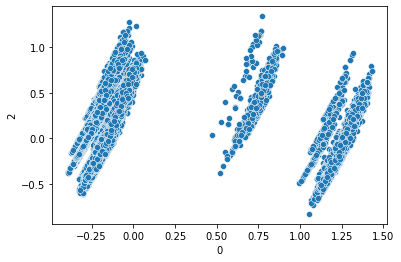

In [42]:
# visualizacion del pca
sns.scatterplot(x=df_pca[0], y=df_pca[2])
plt.show()

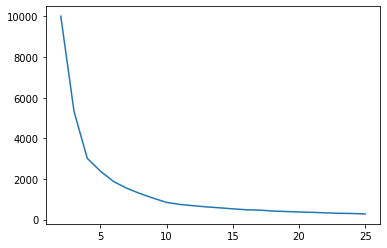

In [31]:
from sklearn.cluster import KMeans

ssd = []
for i in range(2, 26):
    km = KMeans(n_clusters=i)
    km.fit_predict(df_pca)
    ssd.append(km.inertia_)
plt.plot(range(2, 26), ssd)
plt.show()

In [34]:
km = KMeans(n_clusters=3).fit(df_pca)
l = km.predict(df_pca)
data_dummies.shape, df_pca.shape

((47573, 70), (47573, 3))

In [35]:
df_cluster = pd.DataFrame()

In [36]:
# ponerle las etiquetaas a los data sets
df_cluster['lat']=data_dummies['lat']
df_cluster['lon']=data_dummies['lon']
df_cluster['Etiquetas']=l
df_cluster['l3']=dataP2['l3']

In [37]:
df_cluster.head()

,lat,lon,Etiquetas,l3
0,-34.605880,-58.384949,0,San Cristobal
1,-34.624056,-58.412110,1,Boedo
2,-34.593569,-58.427474,1,Palermo
3,-34.581294,-58.436754,1,Palermo
5,-34.593779,-58.441239,1,Villa Crespo


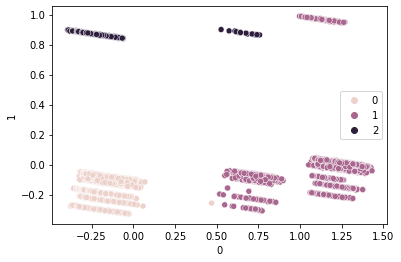

In [38]:
labels_1 = km.labels_
sns.scatterplot(x=df_pca[0], y=df_pca[1], hue=labels_1)
plt.show()

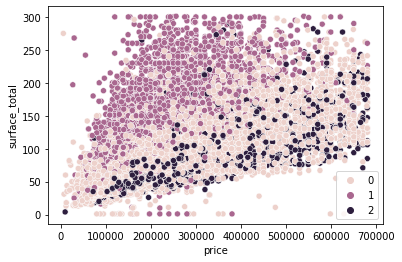

In [39]:
sns.scatterplot(x=data_dummies['price'], y=data_dummies['surface_total'], hue=labels_1)
plt.show()

## Clusterizado con dbscan

In [52]:
from sklearn.cluster import DBSCAN
db = DBSCAN()
l2 = db.fit_predict(df_pca[[0,1,2]])

In [53]:
df_cluster2 = pd.DataFrame()
# ponerle las etiquetaas a los data sets
df_cluster2['lat']=data_dummies['lat']
df_cluster2['lon']=data_dummies['lon']
df_cluster2['Etiquetas']=l2
df_cluster2['l3']=dataP2['l3']

In [54]:
df_cluster2.head()

,lat,lon,Etiquetas,l3
0,-34.605880,-58.384949,0,San Cristobal
1,-34.624056,-58.412110,1,Boedo
2,-34.593569,-58.427474,2,Palermo
3,-34.581294,-58.436754,2,Palermo
5,-34.593779,-58.441239,1,Villa Crespo


In [55]:
# el dbscan encontro 45 centros de clsuters
np.unique(db.labels_)

array([0, 1, 2, 3, 4], dtype=int64)

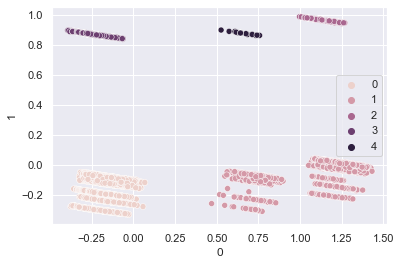

In [59]:
sns.scatterplot(x=df_pca[0], y=df_pca[1], hue=l2)
plt.show()

En el proceso de clusterizado con DBSCAN podemos ver que los clusters en la parte inferior del grafico corresponden a las propiedades en localidades que no estan muy representadas nuemricamente en el dataset, pues el pca 2 tiene como componentes mas importantes las localidades con mas numero de propiedades en el dataset. Asi mismo las propiedades con un vlor alto en y son propiedades que estan dentro del tipo de propiedad mas comun en el data set.
En la grafica tambien podemos ver que el proceso de cluterizado separa horizontalmente algunos algunos puntos. El pca 0 es el que tiene como valores mas importantes el tipo de propiedad y la superficie total. Asi que podriamos decir que el label 0 tal vez se refiere a el tipo de propiedad casa (el menos comun en el data set) y los otros a los de departamento y ph, como estos son mas parecidos entre si estan representados con el mismo color.

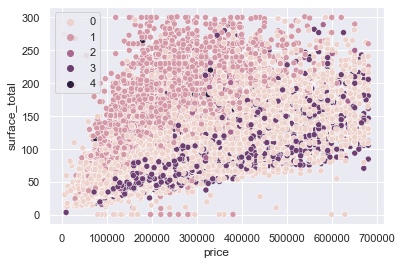

In [58]:
sns.set()
sns.scatterplot(x=data_dummies['price'], y=data_dummies['surface_total'], hue_order=['1','2','0'], hue=l2)
plt.show()

## Conclusiones de la clusterizacion:
Del anterior proceso de clusterizado podemos decir varias cosas.
En este ejercicio lo que hicimos fue clusterizar el data set con todos los componentes del dataset despues de su transformacion con el Principa Component Analisis. Asi que con esto clusterizamos todo el dataset. 
Por esta razon los algoritmos que usamos separan en clusters tomando como criterio todas las caractiristicas de las propiedades, y como son tantos atributos (18) es muy dificil para un humano ver un sentido en esta clusterizacion de forma grafica.
Para poder ver algo de este proceso de clusterizado y no solo confiar en el hacemos un clusterizado solo de 3 labels con kmeans. Este proceso nos arroja un clusterizado que parece ser sensible al precio y a la superficie total (labels 1 y 2) pero la label 0 no parece tener mucha diferencia con la 1 excpetuando que tiene menos valores. Talvez las propiedades label 0 se refieran a tipo de propiedad mas que a superficie o precio, esto considerando el resultado del PCA que arrojo la importancia de la superficie y el tipo de propiedad para la varianza del dataset.